In [ ]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate, Flatten, LSTM, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D, GRU, SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, RNN
from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve
from gensim.models.keyedvectors import KeyedVectors
import gc
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import warnings

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/EP/Komentar_EP.xlsx', sheet_name='Result_Tagged')
df.head()

,Username,Comment,POS,NET,NEG
0,Talitha Amalia,Aamiin. Semoga kampus cepat buka☺🙏,1.0,0.0,0.0
1,Juan Rinaldy Sitorus,Amin semoga kampus bisa cepat melakukan tatap ...,1.0,0.0,0.0
2,Naufal Hanafi,"Semoga bisa kuliah tatap muka, terutama buat m...",1.0,0.0,0.0
3,gunawan7300misteri puzzle - pak gunawan cihuy,RPS nya sangat inspiratif.\n\nSemoga kedepanny...,1.0,0.0,0.0
4,يوسف Ramadan,Kuliah Gak Penting ❎\nSekolah Penting ✅,0.0,1.0,0.0


In [ ]:
#ilangin link dan uname
df["Comment"]=df["Comment"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["Comment"]=df["Comment"].str.lower()
#ilangin simbol
df["Comment"]=df["Comment"].str.replace('[^\w\s]',' ')
#ilangin angka
df["Comment"]=df["Comment"].str.replace('\d+',' ')
#ilangin enter
df["Comment"]=df["Comment"].str.replace('\n',' ',regex=True)
df["Comment"] = df["Comment"].replace('\s+', ' ', regex=True)
df = df.dropna()
df.POS.astype(int)
df['NET'].astype(int)
df['NEG'].astype(int)
df = df.drop('Username', 1)
df

,Comment,POS,NET,NEG
0,aamiin semoga kampus cepat buka,1.0,0.0,0.0
1,amin semoga kampus bisa cepat melakukan tatap ...,1.0,0.0,0.0
2,semoga bisa kuliah tatap muka terutama buat ma...,1.0,0.0,0.0
3,rps nya sangat inspiratif semoga kedepannya da...,1.0,0.0,0.0
4,kuliah gak penting sekolah penting,0.0,1.0,0.0
...,...,...,...,...
556,komentar no,0.0,1.0,0.0
557,pak dalan e do ajur kabeh,0.0,1.0,0.0
558,pak ganjar is the best candidate for president...,0.0,1.0,0.0
559,preet,0.0,1.0,0.0


In [ ]:
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0.0    340
1.0    210
Name: POS, dtype: int64
0.0    305
1.0    245
Name: NET, dtype: int64
0.0    455
1.0     95
Name: NEG, dtype: int64


In [ ]:
df_majority = df[df.NEG== 0 ]

df_minority = df[df.NEG== 1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=245,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_majority_2 = df_upsampled[df_upsampled.POS== 0 ]

df_minority_2 = df_upsampled[df_upsampled.POS== 1]

df_minority_upsampled_2 = resample(df_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=245,    # to match majority class
                                 random_state=123)   # reproducible results
df_upsampled_2 = pd.concat([df_majority_2, df_minority_upsampled_2])
df = df_upsampled_2
print(df.POS.value_counts())
print(df.NET.value_counts())
print(df.NEG.value_counts())

0.0    490
1.0    245
Name: POS, dtype: int64
0.0    490
1.0    245
Name: NET, dtype: int64
0.0    490
1.0    245
Name: NEG, dtype: int64


In [ ]:
df['POS']=df['POS'].astype(int)
df['NET']=df['NET'].astype(int)
df['NEG']=df['NEG'].astype(int)
train, test = train_test_split(df, test_size=0.2, random_state = 23)
list_classes = ['POS','NET','NEG']
y = train[list_classes].values
y_te = test[list_classes].values
list_sentences_train = train["Comment"]
list_sentences_test = test["Comment"]
max_features = 100000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
maxlen = 50
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

In [ ]:
def loadEmbeddingMatrix(typeToLoad):
        #load different embedding file from Kaggle depending on which embedding 
        #matrix we are going to experiment with
        if(typeToLoad=="word2vec"):
            word2vecDict = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin", binary=True)
            embed_size = 300
            embeddings_index = dict()
            for word in word2vecDict.wv.vocab:
                embeddings_index[word] = word2vecDict.word_vec(word)
            print('Loaded %s word vectors.' % len(embeddings_index))
            
        gc.collect()
        #We get the mean and standard deviation of the embedding weights so that we could maintain the 
        #same statistics for the rest of our own random generated weights. 
        all_embs = np.stack(list(embeddings_index.values()))
        emb_mean,emb_std = all_embs.mean(), all_embs.std()
        
        nb_words = len(tokenizer.word_index)+1
        #We are going to set the embedding size to the pretrained dimension as we are replicating it.
        #the size will be Number of Words in Vocab X Embedding Size
        embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
        gc.collect()

        #With the newly created embedding matrix, we'll fill it up with the words that we have in both 
        #our own dictionary and loaded pretrained embedding. 
        embeddedCount = 0
        for word, i in tokenizer.word_index.items():
            i-=1
            #then we see if this word is in glove's dictionary, if yes, get the corresponding weights
            embedding_vector = embeddings_index.get(word)
            #and store inside the embedding matrix that we will train later on.
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
                embeddedCount+=1
        print('total embedded:',embeddedCount,'common words')
        
        del(embeddings_index)
        gc.collect()
        
        #finally, return the embedding matrix
        return embedding_matrix

In [ ]:
def create_fold_embeddings(embeddings_dim, key_vector):
    
    emb_init_values = []
    unk = []

    a = 0
    b = 0

    for word, i in tokenizer.word_index.items():  # Untuk memastikan bahwa urut
        if word == '<unk>':
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))

        elif word == '<pad>':
            emb_init_values.append(np.zeros(embeddings_dim).astype('float32'))
                    
        elif word in key_vector.wv.vocab:
            emb_init_values.append(key_vector.wv.word_vec(word))
            b = b+1
        else:
            emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
            a = a+1
            unk.append(word)
            # print(word)
    emb_init_values.append(np.random.uniform(-0.25, 0.25, embeddings_dim).astype('float32'))
    known_word = b
    unknown_word = a

    print(known_word, unknown_word)

    return known_word, unknown_word, emb_init_values

In [ ]:
word_vectors = KeyedVectors.load_word2vec_format("/content/drive/MyDrive/model300.bin",binary="True", unicode_errors='ignore')
word2vec = word_vectors
embed_dim = 300

In [ ]:
known_word, unknown_word, emb_init_values = create_fold_embeddings(embed_dim, word_vectors)
emb_init_values = np.array(emb_init_values)
print("known words:", known_word)
print("unknown words:", unknown_word)

1607 286
known words: 1607
unknown words: 286


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


In [ ]:
class RocAucEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0)
            score = roc_auc_score(self.y_val, y_pred)
            print("\n ROC-AUC - epoch: %d - score: %.6f \n" % (epoch+1, score))
inp = Input(shape=(maxlen,))


In [ ]:
x = Embedding(len(tokenizer.word_index)+1, emb_init_values.shape[1],weights=[emb_init_values],trainable=True)(inp)
# print(inp.shape)
x = LSTM(200, activation='tanh', return_sequences = True, dropout=0.4)(x)
#x = GRU(200, return_sequences=True)(x)

x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(100)(x)
x = Dropout(0.1)(x)
x = Dense(50)(x)
x = Dropout(0.1)(x)
x = Dense(28, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(3, activation="softmax")(x)


model = Model(inputs=inp, outputs=x)
opt = tf.keras.optimizers.Adam(lr=0.01)
model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

batch_size = 64
epochs = 100

# file_path="weights_base.best.hdf5"
RocAuc = RocAucEvaluation(validation_data=(X_te, y_te), interval=1)
# checkpoint = ModelCheckpoint('modelEmb-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
model.fit(X_t,y, batch_size=batch_size, epochs=epochs,  verbose=2,callbacks=[RocAuc], validation_data=(X_te, y_te))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
10/10 - 6s - loss: 0.9513 - accuracy: 0.3946 - val_loss: 0.8032 - val_accuracy: 0.2993

 ROC-AUC - epoch: 1 - score: 0.536777 

Epoch 2/50
10/10 - 3s - loss: 0.6649 - accuracy: 0.4201 - val_loss: 0.6445 - val_accuracy: 0.4286

 ROC-AUC - epoch: 2 - score: 0.623635 

Epoch 3/50
10/10 - 3s - loss: 0.6125 - accuracy: 0.4983 - val_loss: 0.6435 - val_accuracy: 0.3946

 ROC-AUC - epoch: 3 - score: 0.598340 

Epoch 4/50
10/10 - 3s - loss: 0.5653 - accuracy: 0.5102 - val_loss: 0.6541 - val_accuracy: 0.5170

 ROC-AUC - epoch: 4 - score: 0.704563 

Epoch 5/50
10/10 - 3s - loss: 0.4968 - accuracy: 0.6310 - val_loss: 0.7509 - val_accuracy: 0.4966

 ROC-AUC - epoch: 5 - score: 0.731894 

Epoch 6/50
10/10 - 3s - loss: 0.4177 - accuracy: 0.6956 - val_loss: 0.5406 - val_accuracy: 0.6531

 ROC-AUC - epoch: 6 - score: 0.829193 

Epoch 7/50
10/10 - 3s - loss: 0.2685 - accuracy: 0.8384 - val_loss: 0.6747 - val_accuracy: 0.7007

 ROC-AUC - epoch: 7 - score: 0.862129 

Epoch 8/50
10/10 - 3s - los

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 300)           568200    
_________________________________________________________________
lstm_3 (LSTM)                (None, 50, 200)           400800    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0   

In [ ]:
from keras.models import load_model
c = model.predict(X_te)
score = model.evaluate(X_te, y_te,
                       batch_size=batch_size, verbose=1)
print('Test accuracy:', score[1])

3/3 [==============================] - 0s 59ms/step - loss: 2.0646 - accuracy: 0.7823
Test accuracy: 0.7823129296302795


In [ ]:
y_pred = model.predict(X_te)
roc_auc_score(y_te, c)

0.9083669422270341

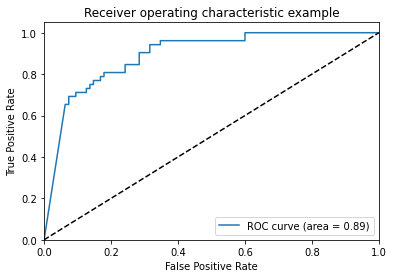

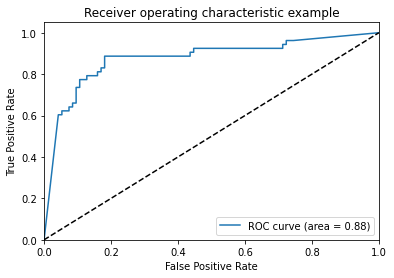

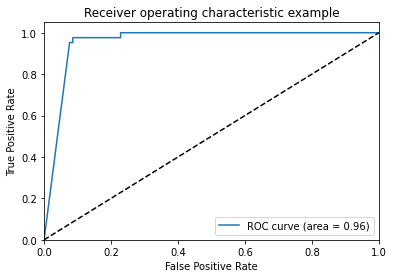

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
for i in range(3):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
y_pred[y_pred>=0.23] = 1
y_pred[y_pred<0.23] = 0
roc_auc_score(y_te, y_pred)

0.8452560397948004

In [ ]:
import sklearn.metrics as skm
import numpy as np
cm = skm.multilabel_confusion_matrix(y_te, y_pred)
print(cm)
print( skm.classification_report(y_te,y_pred))

[[[88  7]
  [17 35]]

 [[84 10]
  [13 40]]

 [[89 16]
  [ 1 41]]]
              precision    recall  f1-score   support

           0       0.83      0.67      0.74        52
           1       0.80      0.75      0.78        53
           2       0.72      0.98      0.83        42

   micro avg       0.78      0.79      0.78       147
   macro avg       0.78      0.80      0.78       147
weighted avg       0.79      0.79      0.78       147
 samples avg       0.79      0.79      0.79       147



In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)
print('Hamming score: {0}'.format(hamming_score(y_te,y_pred)))


Hamming score: 0.7857142857142857


In [ ]:
import sklearn.metrics
# Subset accuracy
# 0.25 (= 0+1+0+0 / 4) --> 1 if the prediction for one sample fully matches the gold. 0 otherwise.
print('Subset accuracy: {0}'.format(sklearn.metrics.accuracy_score(y_te, y_pred, normalize=True, sample_weight=None)))

# Hamming loss (smaller is better)
# $$ \text{HammingLoss}(x_i, y_i) = \frac{1}{|D|} \sum_{i=1}^{|D|} \frac{xor(x_i, y_i)}{|L|}, $$
# where
#  - \\(|D|\\) is the number of samples  
#  - \\(|L|\\) is the number of labels  
#  - \\(y_i\\) is the ground truth  
#  - \\(x_i\\)  is the prediction.  
# 0.416666666667 (= (1+0+3+1) / (3*4) )
print('Hamming loss: {0}'.format(sklearn.metrics.hamming_loss(y_te, y_pred)))

Subset accuracy: 0.782312925170068
Hamming loss: 0.14512471655328799


In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1))

array([[35, 10,  7],
       [ 6, 40,  7],
       [ 1,  0, 41]])

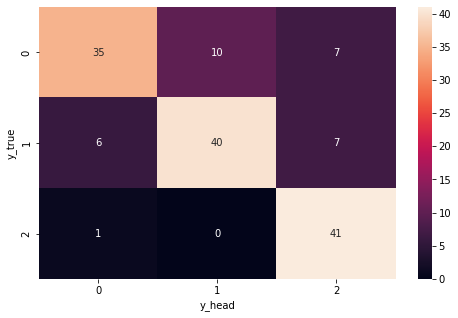

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(8,5))
sns.heatmap(confusion_matrix(y_te.argmax(axis=1), y_pred.argmax(axis=1)), annot=True, fmt=".0f", ax=ax)
plt.xlabel("y_head")
plt.ylabel("y_true")
plt.show()

In [ ]:
df_untagged = pd.read_excel('/content/drive/MyDrive/EP/Komentar_EP.xlsx', sheet_name='Result_Untagged')
df_untagged.head()

,Username,Comment
0,Anak Agung Grendawardana,Aku sudah capek di PHP sm Mendikbud 😭😭😭 \nJuli...
1,Nicholas Junaedi,Gurunya sih divaksin muridnya gimanaa aing.......
2,Ranny Kroya,"Alhamdulilah semoga saja cpt masuk sekolah, u..."
3,Inzaghi Posuma Al Kahfi,Seharusnya semua Sekolah di Indonesia menerapk...
4,XI IPA 3 Absen 16 Ananta,Wacanaaaaaaaaa


In [ ]:
#ilangin link dan uname
df_untagged["Comment"]=df_untagged["Comment"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df_untagged["Comment"]=df_untagged["Comment"].str.lower()
#ilangin simbol
df_untagged["Comment"]=df_untagged["Comment"].str.replace('[^\w\s]',' ')
#ilangin angka
df_untagged["Comment"]=df_untagged["Comment"].str.replace('\d+',' ')
#ilangin enter
df_untagged["Comment"]=df_untagged["Comment"].str.replace('\n',' ',regex=True)
df_untagged["Comment"] = df_untagged["Comment"].replace('\s+', ' ', regex=True)
df_untagged

,Username,Comment
0,Anak Agung Grendawardana,aku sudah capek di php sm mendikbud juli ktny ...
1,Nicholas Junaedi,gurunya sih divaksin muridnya gimanaa aing sek...
2,Ranny Kroya,alhamdulilah semoga saja cpt masuk sekolah udh...
3,Inzaghi Posuma Al Kahfi,seharusnya semua sekolah di indonesia menerapk...
4,XI IPA 3 Absen 16 Ananta,wacanaaaaaaaaa
...,...,...
1193,dark_shadow135,noooooo
1194,khansa arkhap,hoax
1195,Wisnu H,no way
1196,미라Myra,tidak jadi


In [ ]:
list_sentences_aplikasi = df_untagged["Comment"]
list_tokenized_aplikasi = tokenizer.texts_to_sequences(list_sentences_aplikasi)
X_aplikasi = pad_sequences(list_tokenized_aplikasi, maxlen=maxlen)
X_aplikasi

array([[   0,    0,    0, ..., 1753,   47,    9],
       [   0,    0,    0, ...,  178,   21,  686],
       [   0,    0,    0, ...,  895, 1751, 1044],
       ...,
       [   0,    0,    0, ...,    0,  646, 1680],
       [   0,    0,    0, ...,    0,   21,   17],
       [   0,    0,    0, ...,    0,  318,   20]], dtype=int32)

In [ ]:
y_pred_aplikasi = model.predict(X_aplikasi)
y_pred_aplikasi

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [9.9999154e-01, 6.2190406e-06, 2.3219675e-06],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       ...,
       [1.9912486e-24, 1.0000000e+00, 1.8487812e-19],
       [2.9840337e-06, 9.7749215e-01, 2.2504756e-02],
       [7.3205963e-02, 3.7698636e-03, 9.2302418e-01]], dtype=float32)

In [ ]:
dfhasil = pd.DataFrame(y_pred_aplikasi, columns=['POS', 'NET', 'NEG'])
dfhasil

,POS,NET,NEG
0,1.000000e+00,0.000000,0.000000e+00
1,9.999915e-01,0.000006,2.321967e-06
2,1.000000e+00,0.000000,0.000000e+00
3,1.000000e+00,0.000000,0.000000e+00
4,3.139209e-22,1.000000,1.335163e-18
...,...,...,...
1193,3.139209e-22,1.000000,1.335163e-18
1194,1.990148e-08,0.999996,4.008105e-06
1195,1.991249e-24,1.000000,1.848781e-19
1196,2.984034e-06,0.977492,2.250476e-02


In [ ]:
dfhasilramal = dfhasil.eq(dfhasil.where(dfhasil != 0).max(1), axis=0).astype(int)
dfhasilramal

,POS,NET,NEG
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,0,1,0
...,...,...,...
1193,0,1,0
1194,0,1,0
1195,0,1,0
1196,0,1,0


In [ ]:
finalresult = pd.concat([df_untagged, dfhasilramal], axis=1, sort=False)
finalresult

,Username,Comment,POS,NET,NEG
0,Anak Agung Grendawardana,aku sudah capek di php sm mendikbud juli ktny ...,1,0,0
1,Nicholas Junaedi,gurunya sih divaksin muridnya gimanaa aing sek...,1,0,0
2,Ranny Kroya,alhamdulilah semoga saja cpt masuk sekolah udh...,1,0,0
3,Inzaghi Posuma Al Kahfi,seharusnya semua sekolah di indonesia menerapk...,1,0,0
4,XI IPA 3 Absen 16 Ananta,wacanaaaaaaaaa,0,1,0
...,...,...,...,...,...
1193,dark_shadow135,noooooo,0,1,0
1194,khansa arkhap,hoax,0,1,0
1195,Wisnu H,no way,0,1,0
1196,미라Myra,tidak jadi,0,1,0


In [ ]:
finalresult.to_excel('/content/drive/MyDrive/EP/hasil_ramal_untagged.xlsx', index=False)

In [ ]:
finalresult.POS.value_counts()

0    828
1    370
Name: POS, dtype: int64

In [ ]:
finalresult.NET.value_counts()

0    641
1    557
Name: NET, dtype: int64

In [ ]:
finalresult.NEG.value_counts()

0    927
1    271
Name: NEG, dtype: int64

In [ ]:
df_tagged = pd.read_excel('/content/drive/MyDrive/EP/Komentar_EP.xlsx', sheet_name='Result_Tagged')
df_auto_tagged = pd.read_excel('/content/drive/MyDrive/EP/hasil_ramal_untagged.xlsx')
df= df_tagged.append(df_auto_tagged)
df

,Username,Comment,POS,NET,NEG
0,Talitha Amalia,Aamiin. Semoga kampus cepat buka☺🙏,1.0,0.0,0.0
1,Juan Rinaldy Sitorus,Amin semoga kampus bisa cepat melakukan tatap ...,1.0,0.0,0.0
2,Naufal Hanafi,"Semoga bisa kuliah tatap muka, terutama buat m...",1.0,0.0,0.0
3,gunawan7300misteri puzzle - pak gunawan cihuy,RPS nya sangat inspiratif.\n\nSemoga kedepanny...,1.0,0.0,0.0
4,يوسف Ramadan,Kuliah Gak Penting ❎\nSekolah Penting ✅,0.0,1.0,0.0
...,...,...,...,...,...
1193,dark_shadow135,noooooo,0.0,1.0,0.0
1194,khansa arkhap,hoax,0.0,1.0,0.0
1195,Wisnu H,no way,0.0,1.0,0.0
1196,미라Myra,tidak jadi,0.0,1.0,0.0


In [ ]:
df.to_excel('/content/drive/MyDrive/EP/otw_LDA.xlsx', index=False)

In [ ]:
df=pd.read_excel('/content/drive/MyDrive/EP/otw_LDA.xlsx')

In [ ]:
df["Comment"]=df["Comment"].str.replace('(?:\@|https?\://)\S+', '')
#ilangin lowercase
df["Comment"]=df["Comment"].str.lower()
#ilangin simbol
df["Comment"]=df["Comment"].str.replace('[^\w\s]',' ')
#ilangin angka
df["Comment"]=df["Comment"].str.replace('\d+',' ')
#ilangin enter
df["Comment"]=df["Comment"].str.replace('\n',' ',regex=True)
df["Comment"] = df["Comment"].replace('\s+', ' ', regex=True)
df = df.dropna()

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop1 = {}
df['Comment'] = df['Comment'].astype(str)
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop1)]))

stop2 = stopwords.words('indonesian')
df['Comment'] = df['Comment'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop2)]))
df



<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:1: DeprecationWarning: invalid escape sequence \@
<input>:5: DeprecationWarning: invalid escape sequence \w
<input>:7: DeprecationWarning: invalid escape sequence \d
<input>:1: Dep

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,Username,Comment,POS,NET,NEG
0,Talitha Amalia,aamiin semoga kampus cepat buka,1.0,0.0,0.0
1,Juan Rinaldy Sitorus,amin semoga kampus cepat tatap muka,1.0,0.0,0.0
2,Naufal Hanafi,semoga kuliah tatap muka maba takut gak dapet ...,1.0,0.0,0.0
3,gunawan7300misteri puzzle - pak gunawan cihuy,rps nya inspiratif semoga kedepannya menjadika...,1.0,0.0,0.0
4,يوسف Ramadan,kuliah gak sekolah,0.0,1.0,0.0
...,...,...,...,...,...
1754,dark_shadow135,noooooo,0.0,1.0,0.0
1755,khansa arkhap,hoax,0.0,1.0,0.0
1756,Wisnu H,no way,0.0,1.0,0.0
1757,미라Myra,,0.0,1.0,0.0


In [ ]:
df_POS = df.loc[df['POS'] == 1]
df_NET = df.loc[df['NET'] == 1]
df_NEG = df.loc[df['NEG'] == 1]

In [ ]:
!pip install pyLDAvis
!pip install openpyxl==3.0.0

     |████████████████████████████████| 1.7 MB 5.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 15.7 MB 190 kB/s 
     |████████████████████████████████| 11.3 MB 55.1 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136897 sha256=c822db9f2f497ca10be3a0310894fb1369f9071ce2f3a2d4ebbd2f56d69a2cbe
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take int

     |████████████████████████████████| 172 kB 5.0 MB/s 
  Created wheel for openpyxl: filename=openpyxl-3.0.0-py2.py3-none-any.whl size=241208 sha256=17b5ee4924fdea4b52c953a71434f9423b5fcfb1b3549199b08e805764219b8b
  Stored in directory: /root/.cache/pip/wheels/c7/64/ff/ce98f6e1d2701ae8e216c875da62feed2839ac8a3cae0ab8af
Successfully built openpyxl
  Attempting uninstall: openpyxl
    Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
# -*- coding: utf-8 -*-
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle 
import numpy as np, pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

random_state = 0 

#Ganti_disini
#df = pd.read_csv('CommentYoutube.csv')
#df=df.dropna()

doc_set = df_POS['Comment']
#doc_set.str.split("\n")[1:-1]
doc_set

0                         aamiin semoga kampus cepat buka
1                     amin semoga kampus cepat tatap muka
2       semoga kuliah tatap muka maba takut gak dapet ...
3       rps nya inspiratif semoga kedepannya menjadika...
7                                        aamiin ya allaah
                              ...                        
1737    melawak lu tong ha covid gini masuk resiko tan...
1743    bismillahirrahmanirrahim siswa mahasiswa pelaj...
1745    siswa sma kelas mengaku stres pembelajaran onl...
1747    tdk grusah grusuh belajar sekolah tatap muka m...
1750    subrek channel semoga rezekinya ngalir yg jodo...
Name: Comment, Length: 580, dtype: object

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

4 -8.459141163151692 0.31197736093041456
   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             2.0              0.9940   
1            1             2.0              0.9926   
2            2             0.0              0.9973   
3            3             0.0              0.9963   
4            4             0.0              0.4951   
5            5             2.0              0.6240   
6            6             2.0              0.9712   
7            7             3.0              0.9712   
8            8             2.0              0.9981   
9            9             3.0              0.9957   

                                            Keywords  \
0  anak, semoga, online, orang, buka, tua, pemeri...   
1  anak, semoga, online, orang, buka, tua, pemeri...   
2  anak, aja, covid, kena, orang, siswa, protokol...   
3  anak, aja, covid, kena, orang, siswa, protokol...   
4  anak, aja, covid, kena, orang, siswa, protokol...   
5  anak, semoga, online, ora

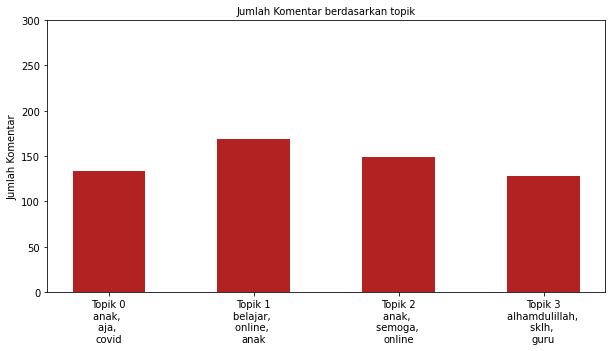

In [ ]:

#Ganti_disini
stopword = ['sekolah', 'tatap', 'muka', 'nya', 'gak', 'utk']

tokenizer = RegexpTokenizer(r'\w+')


# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set.astype(str):
    
    # clean and tokenize document string
    raw = i.lower()
    raw =  re.sub(r'\b[0-9(.,)+]*\b', '', raw)
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopword and len(i) > 2]
    
    
    # add tokens to list
    texts.append(stopped_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
#Ganti_disini
for k in range(4, 5):
	# generate LDA model
	ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
	#print(ldamodel.show_topics())
	# Compute Coherence Score
	coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
	coherence_lda = coherence_model_lda.get_coherence()
	print(k,ldamodel.log_perplexity(corpus),coherence_lda)  # a measure of how good the model is. lower the better.


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.options.display.max_columns=50
print(df_dominant_topic.head(10))



# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc )
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10,5))

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topik ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Jumlah Komentar berdasarkan topik', fontdict=dict(size=10))
ax1.set_ylabel('Jumlah Komentar')
ax1.set_ylim(0, 300)


plt.show()

In [ ]:
# -*- coding: utf-8 -*-
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle 
import numpy as np, pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

random_state = 0 

#Ganti_disini
#df = pd.read_csv('CommentYoutube.csv')
#df=df.dropna()

doc_set = df_NET['Comment']
#doc_set.str.split("\n")[1:-1]
doc_set

4                                      kuliah gak sekolah
6                    jam pembelajaran kuliah diperhatikan
17      klo menunggu selesainya covid tdk selesai hrs ...
18                   nih main hp hayoloh sekolah gapinter
29                                        kabar september
                              ...                        
1753                                                  noo
1754                                              noooooo
1755                                                 hoax
1756                                               no way
1757                                                     
Name: Comment, Length: 800, dtype: object

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

4 -8.891362675818248 0.5403758802634342
   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             1.0              0.9712   
1            1             1.0              0.9926   
2            2             3.0              0.9970   
3            3             1.0              0.9926   
4            4             3.0              0.9853   
5            5             1.0              0.9712   
6            6             0.0              0.9712   
7            7             0.0              0.9940   
8            8             3.0              0.9940   
9            9             0.0              0.9926   

                                            Keywords  \
0  gubernur, mantap, gimana, ganjar, hati, zona, ...   
1  gubernur, mantap, gimana, ganjar, hati, zona, ...   
2  ganjar, anak, masuk, corona, udah, aja, covid,...   
3  gubernur, mantap, gimana, ganjar, hati, zona, ...   
4  ganjar, anak, masuk, corona, udah, aja, covid,...   
5  gubernur, mantap, gimana, 

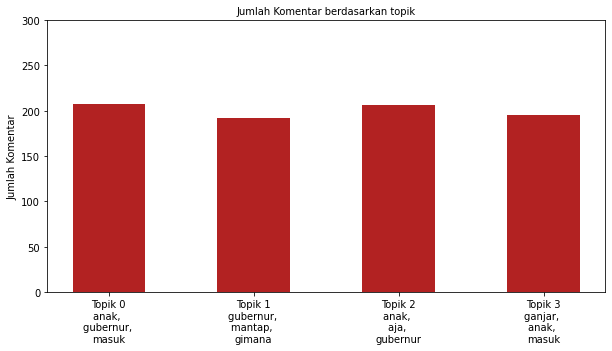

In [ ]:

#Ganti_disini
stopword = ['sekolah', 'tatap', 'muka', 'nya', 'gak', 'utk']

tokenizer = RegexpTokenizer(r'\w+')


# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set.astype(str):
    
    # clean and tokenize document string
    raw = i.lower()
    raw =  re.sub(r'\b[0-9(.,)+]*\b', '', raw)
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopword and len(i) > 2]
    
    
    # add tokens to list
    texts.append(stopped_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
#Ganti_disini
for k in range(4, 5):
	# generate LDA model
	ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
	#print(ldamodel.show_topics())
	# Compute Coherence Score
	coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
	coherence_lda = coherence_model_lda.get_coherence()
	print(k,ldamodel.log_perplexity(corpus),coherence_lda)  # a measure of how good the model is. lower the better.


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.options.display.max_columns=50
print(df_dominant_topic.head(10))



# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc )
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10,5))

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topik ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Jumlah Komentar berdasarkan topik', fontdict=dict(size=10))
ax1.set_ylabel('Jumlah Komentar')
ax1.set_ylim(0, 300)


plt.show()

In [ ]:
# -*- coding: utf-8 -*-
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle 
import numpy as np, pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

random_state = 0 

#Ganti_disini
#df = pd.read_csv('CommentYoutube.csv')
#df=df.dropna()

doc_set = df_NEG['Comment']
#doc_set.str.split("\n")[1:-1]
doc_set

5       knpa tdk kebijakan kesini kebijakan nya batal ...
14       buktikan php mulu dsni dosen sdh keenakan online
19                                        dah lh php mulu
20                               ujung kaga kuliah ofline
21                     hoax kuliah tatap muka rencana aja
                              ...                        
1741            angka blum turun² udah buka sekolah hadeh
1742                                               setuju
1746                                               setuju
1748                                               setuju
1758                                              pjj aja
Name: Comment, Length: 366, dtype: object

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

4 -8.183266243142798 0.4544850419571139
   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             0.0              0.9979   
1            1             0.0              0.9963   
2            2             3.0              0.9901   
3            3             1.0              0.9926   
4            4             2.0              0.9926   
5            5             1.0              0.9712   
6            6             1.0              0.9967   
7            7             3.0              0.9712   
8            8             0.0              0.9712   
9            9             0.0              0.9926   

                                            Keywords  \
0  anak, aja, online, masuk, belajar, kuliah, dar...   
1  anak, aja, online, masuk, belajar, kuliah, dar...   
2  anak, covid, setuju, aja, kena, daring, kalo, ...   
3  online, mentri, covid, buka, gua, aja, orang, ...   
4  aja, anak, orang, online, corona, belajar, men...   
5  online, mentri, covid, buk

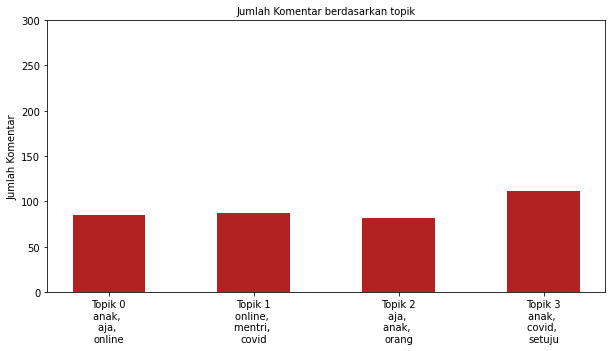

In [ ]:

#Ganti_disini
stopword = ['sekolah', 'tatap', 'muka', 'nya', 'gak', 'utk']

tokenizer = RegexpTokenizer(r'\w+')


# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set.astype(str):
    
    # clean and tokenize document string
    raw = i.lower()
    raw =  re.sub(r'\b[0-9(.,)+]*\b', '', raw)
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopword and len(i) > 2]
    
    
    # add tokens to list
    texts.append(stopped_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
#Ganti_disini
for k in range(4, 5):
	# generate LDA model
	ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
	#print(ldamodel.show_topics())
	# Compute Coherence Score
	coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
	coherence_lda = coherence_model_lda.get_coherence()
	print(k,ldamodel.log_perplexity(corpus),coherence_lda)  # a measure of how good the model is. lower the better.


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.options.display.max_columns=50
print(df_dominant_topic.head(10))



# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc )
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

fig, ax1 = plt.subplots(figsize=(10,5))

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topik ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Jumlah Komentar berdasarkan topik', fontdict=dict(size=10))
ax1.set_ylabel('Jumlah Komentar')
ax1.set_ylim(0, 300)


plt.show()